In [ ]:
# 生成用户侧的三个特征
# NOTE: 重构了部分TR代码

In [1]:
# Preliminaries

import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from utils import load_pickle, save_pickle, wrap
from lib.log import logger

# graph = load_pickle("/root/Lab_Related/data/Heter-GAT/Classic/graph/graph-directed.p")
# diffusion_dict = load_pickle("/root/Lab_Related/data/Heter-GAT/Classic/ActionLog.p")

# graph_vcount = graph.vcount()
# Ntimestages = 8
# # NOTE: valid_users are those whose out degree are 0
# active_users = load_pickle("user_features/valid_users.p")

2022-09-12 10:13:15,056 Note: NumExpr detected 56 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-09-12 10:13:15,059 NumExpr defaulting to 8 threads.


In [ ]:
# NOTE: Calculate Gravity Feature
# 2-1. Calculate Gravity Feature: 1 * |V-Candidates|
import math
import copy

def get_gravity_feature(active_users, order_t, tao_t):
    gravity_feature = [0. for _ in range(graph_vcount)]
    # beta = 1.0 # no affect to ranking result, 因为大家都乘系数等于大家都不乘
    logger.info("Start Computing Gra-Feat")
    cnt = 0
    for active_user in active_users:
        cnt += 1
        if cnt % 1000 == 0:
            logger.info(f"[Debug] calculated {cnt} active users in Gravity Feature")

        # activer_degree = graph.degree(active_user, mode="out")
        activer_degree = wrap(graph.degree)(active_user)
        if activer_degree == 0:
            continue
        for order_len in range(1, order_t+1):
            # neighborhood = graph.neighborhood(active_user, order=order_len, mode="out", mindist=order_len)
            neighborhood = wrap(graph.neighborhood)(active_user, order=order_len, mindist=order_len)
            for neighbor_user in neighborhood:
                gravity_feature[neighbor_user] += activer_degree * graph.degree(neighbor_user, mode="in") / pow(order_len, tao_t)

    return gravity_feature

def norm_gra_feat(gra_feat):
    def transform_log(data):
        scaled_data = []
        max_data = math.log(max(data))
        for elem in data:
            if elem == 0:
                elem = 1
            scaled_data.append(math.log(elem) / max_data)
        return scaled_data
    gra_feat = transform_log(gra_feat)

    for hashtag, cascades in diffusion_dict.items():
        logger.info(f"Hashtag={hashtag}")
        time_span = (cascades[-1][1]-cascades[0][1])/Ntimestages
        for tidx in range(Ntimestages):
            gravity_feature = copy.deepcopy(gra_feat)
            upper_b = (tidx+1)*time_span+cascades[0][1]
            beforet_cascades = [elem for elem in cascades if elem[1]<upper_b]
            activers = set(active_users) & set([elem[0] for elem in beforet_cascades])
            for active_user in activers:
                gravity_feature[active_user] = 1

            save_pickle(gravity_feature, f"user_features/norm_gravity_feature/hashtag{hashtag}_t{tidx}.p")

# tau=3 # {1,2,3}
# gravity_feature = get_gravity_feature(
#     active_users=active_users,
#     order_t=2,
#     tao_t=tau,
# )
# save_pickle(gravity_feature, "user_features/gravity_feature.p")
# logger.info(f"Calculated Gravity Feature with hyper-param tao={tau}")

# NOTE: 引力特征中有一部分(8320/208894)的用户没有特征值, 其原因是这些用户的入度为零, 没有其他用户向他传播的路径, 也即不会有已传播邻域节点对他施加影响
# gra_feat = load_pickle("/root/Heter-GAT/src/user_features/gravity_feature.p")
# norm_gra_feat(gra_feat)

In [ ]:
# NOTE: Calc Cascade Embedding Feature
import numpy as np

def read_ce_vector(ce_vector_filepath:str="/root/Lab_Related/data/Heter-GAT/Classic/deepwalk/deep_added64.embeddings"):
    ce_vec_dict = {}
    vocab_size, embed_size = 0, 0
    with open(ce_vector_filepath, 'r') as f:
        for idx, line in enumerate(f):
            if idx == 0:
                vocab_size, embed_size = line.split(' ')
                vocab_size, embed_size = int(vocab_size), int(embed_size)
            else:
                idx, emb = line.split(' ', 1)
                emb = [float(elem) for elem in emb.split(' ')]
                ce_vec_dict[int(idx)] = emb
    # NOTE: uptil here, there is some nodes not included in 'ce_vec_dict', 
    # which have total 0 neighbors in both 'in' and 'out' direction,
    # thus they arent counted on in 'deepwalk' algorithm
    
    # Normalize Each Vector
    norm_ce_vec_dict = {}
    for key, value in ce_vec_dict.items():
        norm_ce_vec_dict[key] = value / np.linalg.norm(value)

    return vocab_size, embed_size, norm_ce_vec_dict

def transform(data: np.array):
    min_, max_ = min(data), max(data)
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    if max_+iqr == min_-iqr:
        return data
    scaled_data = (data-(min_-iqr)) / ((max_+iqr)-(min_-iqr))
    return scaled_data

def get_ce_feature():
    vocab_size, embed_size, norm_ce_vec_dict = read_ce_vector()
    logger.info(f"Reading CE-Vector: vocab_size={vocab_size}, embed_size={embed_size}")
    valid_dict_users = set(sorted(list(norm_ce_vec_dict.keys())))

    for hashtag, cascades in diffusion_dict.items():
        logger.info(f"Hashtag={hashtag}")
        time_span = (cascades[-1][1]-cascades[0][1])/Ntimestages
        for tidx in range(Ntimestages):
            upper_b = (tidx+1)*time_span+cascades[0][1]
            beforet_cascades = [elem for elem in cascades if elem[1]<upper_b]
            activers = valid_dict_users & set([elem[0] for elem in beforet_cascades])
            activers_mat = np.array([norm_ce_vec_dict[active_user] for active_user in activers]).reshape(-1, embed_size)

            ce_feature = [0. for _ in range(208894)]
            for user in valid_dict_users:
                ce_feature[user] = np.matmul(activers_mat, norm_ce_vec_dict[user]).sum()
            ce_feature = transform(ce_feature)
            for active_user in activers:
                ce_feature[active_user] = 1
            save_pickle(ce_feature, f"user_features/norm_ce_feature/hashtag{hashtag}_t{tidx}.p")
    
    # NOTE: Replace Hashtag143 with Avg CE-Feature Values
    # for tidx in range(Ntimestages):
    #     tot_ce_feature = [0. for _ in range(208894)]
    #     for hashtag, cascades in diffusion_dict.items():
    #         lc_ce_feature = load_pickle(f"user_features/norm_ce_feature/hashtag{hashtag}_t{tidx}.p")
    #         tot_ce_feature += lc_ce_feature
    #     tot_ce_feature /= len(diffusion_dict)
    #     save_pickle(tot_ce_feature, f"user_features/norm_ce_feature/hashtag143_t{tidx}.p")

# get_ce_feature()

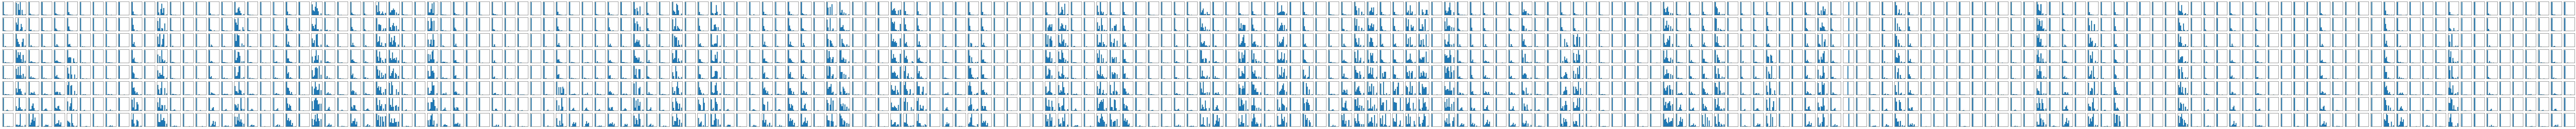

In [2]:
import matplotlib.pyplot as plt

Ntimestages = 8

def plot_features(feature_dirpath: str):
    fig, ax = plt.subplots(8, 200, figsize=(200,10))
    for tidx in range(Ntimestages):
        for hashtag in range(0, 200):
            feat = load_pickle(f"{feature_dirpath}/hashtag{hashtag}_t{tidx}.p")
            ax[tidx][hashtag].hist(feat)
            ax[tidx][hashtag].xaxis.set_visible(False)
            ax[tidx][hashtag].yaxis.set_visible(False)

plot_features("user_features/norm_exptime_feature1/")


In [ ]:
# NOTE: Calc Exposure Time Feature

graph = load_pickle("/root/Lab_Related/data/Heter-GAT/Classic/graph/graph-directed.p")
diffusion_dict = load_pickle("/root/Lab_Related/data/Heter-GAT/Classic/ActionLog.p")

graph_vcount = graph.vcount()
Ntimestages = 8

# 2-2. Exposure Time Feature: 1 * |V-Candidates|
def calc_exptime_sum1():
    for hashtag, cascades in diffusion_dict.items():
        logger.info(f"Hashtag={hashtag}")

        time_span = (cascades[-1][1]-cascades[0][1])/Ntimestages
        for tidx in range(Ntimestages):
            exptime_sum = [0 for _ in range(graph_vcount)]
            upper_b = (tidx+1)*time_span+cascades[0][1]
            beforet_cascade = [elem for elem in cascades if elem[1]<upper_b]
            
            # leave only first appearance of users in 'cascade'
            user_set = set()
            cascade = []
            for elem in beforet_cascade:
                if elem[0] not in user_set:
                    user_set.add(elem[0])
                    cascade.append(elem)
            # cascade = beforet_cascade
            
            for user, timestamp in cascade[1:]:
                last = 0
                in_neighbors = graph.neighbors(user, mode="in")
                while last < len(cascade) and cascade[last][1] < timestamp:
                    # if exists cascade[last][0] -> user relation
                    if cascade[last][0] in in_neighbors:
                        exptime_sum[user] += timestamp - cascade[last][1]
                    last += 1
            logger.info(f"cascade length={len(cascade)}, user_set num={len(user_set)}, valid exptime_sum length={len(list(filter(lambda x: x>0, exptime_sum)))}")
            save_pickle(exptime_sum, f"user_features/exptime_sum1/hashtag{hashtag}_t{tidx}.p")

def calc_exptime_sum2():
    for hashtag, cascades in diffusion_dict.items():
        logger.info(f"Hashtag={hashtag}")

        time_span = (cascades[-1][1]-cascades[0][1])/Ntimestages
        for tidx in range(Ntimestages):
            exptime_sum = [0 for _ in range(graph_vcount)]
            upper_b = (tidx+1)*time_span+cascades[0][1]
            beforet_cascade = [elem for elem in cascades if elem[1]<upper_b]
            
            # leave only first appearance of users in 'cascade'
            user_set = set()
            cascade = []
            for elem in beforet_cascade:
                if elem[0] not in user_set:
                    user_set.add(elem[0])
                    cascade.append(elem)
            # cascade = beforet_cascade
            
            for user, timestamp in cascade[1:]:
                last = 0
                while last < len(cascade) and cascade[last][1] < timestamp:
                    # NOTE: Here is the Diff, dont care whether there is relationship between these two nodes 
                    if user != cascade[last][0]:
                        exptime_sum[user] += timestamp - cascade[last][1]
                    last += 1
            logger.info(f"cascade length={len(cascade)}, user_set num={len(user_set)}, valid exptime_sum length={len(list(filter(lambda x: x>0, exptime_sum)))}")
            save_pickle(exptime_sum, f"user_features/exptime_sum2/hashtag{hashtag}_t{tidx}.p")

def get_exptime_sum_affected():
    for hashtag, cascades in diffusion_dict.items():
        time_span = (cascades[-1][1]-cascades[0][1])/Ntimestages
        for tidx in range(Ntimestages):
            exptime_sum_affected = [0 for _ in range(graph_vcount)]

            upper_b = (tidx+1)*time_span+cascades[0][1]
            beforet_cascade = [elem for elem in cascades if elem[1]<upper_b]
            
            # leave only first appearance of users in 'cascade'
            user_set = set()
            onlyuser_cascade = []
            for elem in beforet_cascade:
                if elem[0] not in user_set:
                    user_set.add(elem[0])
                    onlyuser_cascade.append(elem)
            
            logger.info(f"Hashtag={hashtag}, tidx={tidx}, onlyuser_cascade length={len(onlyuser_cascade)}")
            for active_user, timestamp in onlyuser_cascade:
                for target_user in graph.neighbors(active_user, mode="out"):
                    exptime_sum_affected[target_user] += upper_b - timestamp

            save_pickle(exptime_sum_affected, f"user_features/exptime_sum_affected/hashtag{hashtag}_t{tidx}.p")


In [79]:
# Change ExptimeSum to Exptime-Feat
from astropy.stats import histogram
import numpy as np

# def exptimesum2hists(exptimesum):
#     fltd_sum = list(filter(lambda x:x>0, exptimesum))
#     min_, max_, BIN_NUM = min(fltd_sum), max(fltd_sum), 10
#     bin_range = (max_-min_)/BIN_NUM
#     bins = [min_+i*bin_range for i in range(BIN_NUM)]
#     hists, _ = np.histogram(exptimesum, bins=bins)
#     hists = hists/hists.sum()
#     # logger.info(f"hists={hists}")
#     return hists, bin_range

# def get_exposuretime_feature(hashtag, stage):
#     exptimesum = load_pickle(f"user_features/exptime_sum1/hashtag{hashtag}_t{stage}.p")
#     if len(list(filter(lambda x:x>0, exptimesum))) < 1000:
#         exptimesum = load_pickle(f"user_features/tot_exptime_sum1/t{stage}.p")
#     # exptimesum = load_pickle(f"user_features/tot_exptime_sum/t{stage}.p")
#     hists, bins = exptimesum2hists(exptimesum)
#     affected_exptimesum = load_pickle(f"user_features/exptime_sum_affected/hashtag{hashtag}_t{stage}.p")

#     exptimefeat = []
#     for elem in affected_exptimesum:
#         elem = int(elem/bin_range)
#         elem_feat = hists[elem] if elem < len(hists) else hists[-1]
#         exptimefeat.append(elem_feat)
#     return exptimefeat

def transform(data: np.array):
    min_, max_ = min(data), max(data)
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    if max_+iqr == min_-iqr:
        return data
    scaled_data = (data-(min_-iqr)) / ((max_+iqr)-(min_-iqr))
    return scaled_data

def find_rt_bound(elem, bound_ar):
    idx = 0
    for rt_bound in bound_ar:
        if elem < rt_bound:
            break
        idx += 1
    return idx if idx<len(bound_ar) else len(bound_ar)-1

def hists_fit_transform(fit_data, transform_data):
    """
    Usage: 用fit_data得到数据统计分布, 再用此分布计算transform_data的概率分布值
    """
    # Fit
    fltd_data = list(filter(lambda x:x>0, fit_data))
    hists, bins = histogram(fltd_data, bins='blocks')
    norm_hists = transform(hists)
    
    # Transform
    tf_data = []
    for elem in transform_data:
        rt_bound = find_rt_bound(elem, bins)
        tf_data.append(norm_hists[rt_bound-1])
    return tf_data

def get_exposuretime_feature(hashtag, stage):
    exptimesum = load_pickle(f"user_features/exptime_sum1/hashtag{hashtag}_t{stage}.p")
    if len(list(filter(lambda x:x>0, exptimesum))) < 1000:
        exptimesum = load_pickle(f"user_features/tot_exptime_sum1/t{stage}.p")
    # exptimesum = load_pickle(f"user_features/tot_exptime_sum/t{stage}.p")
    affected_exptimesum = load_pickle(f"user_features/exptime_sum_affected/hashtag{hashtag}_t{stage}.p")

    exptimefeat = hists_fit_transform(exptimesum, affected_exptimesum)
    return exptimefeat

# NOTE: Replace those with too few exptimesum With Tot Distribution
# for tidx in range(Ntimestages):
#     exptime_sum = [0. for _ in range(graph_vcount)]
#     for hashtag, _ in diffusion_dict.items():
#         lc_exptimesum = load_pickle(f"user_features/exptime_sum1/hashtag{hashtag}_t{tidx}.p")
#         exptime_sum = list(map(lambda a,b:a+b, exptime_sum, lc_exptimesum))
#     exptime_sum = [elem/len(diffusion_dict) for elem in exptime_sum]
#     save_pickle(exptime_sum, f"user_features/tot_exptime_sum/t{tidx}.p")

# for tidx in range(8):
#     affected_exptimesum = [0. for _ in range(208894)]
#     for hashtag, _ in diffusion_dict.items():
#         lc_affected_exptimesum = load_pickle(f"user_features/exptime_sum_affected/hashtag{hashtag}_t{tidx}.p")
#         affected_exptimesum = list(map(lambda a,b:a+b, affected_exptimesum, lc_affected_exptimesum))
#     affected_exptimesum = [elem/len(diffusion_dict) for elem in affected_exptimesum]
#     save_pickle(affected_exptimesum, f"user_features/tot_exptime_sum_affected/t{tidx}.p")

# for hashtag, cascades in diffusion_dict.items():
#     logger.info(f"Hashtag={hashtag}")
#     time_span = (cascades[-1][1]-cascades[0][1])/Ntimestages
#     for stage in range(Ntimestages):
#         exptime_feature = get_exposuretime_feature(hashtag, stage)
#         upper_b = (stage+1)*time_span+cascades[0][1]
#         beforet_cascades = [elem for elem in cascades if elem[1]<upper_b]
#         activers = set(active_users) & set([elem[0] for elem in beforet_cascades])
#         for active_user in activers:
#             exptime_feature[active_user] = 1
#         save_pickle(exptime_feature, f"user_features/norm_exptime_feature/hashtag{hashtag}_t{stage}.p")


In [ ]:
# import scipy.stats as st
# import matplotlib.pyplot as plt
# import scipy
# import numpy as np

# def get_best_distribution(data):
#     dist_names = [
#         "beta", "exponweib", "fisk", "gengamma", "halfgennorm", "johnsonsb", "pearson3", "lognorm"
#     ]
#     """
#     p value for beta = 6.202250876777586e-24
#     p value for exponweib = 3.096476501021284e-05
#     p value for fisk = 1.5435224367459432e-22
#     p value for gengamma = 2.728157648263244e-05
#     p value for halfgennorm = 1.2495759423504261e-23
#     p value for johnsonsb = 2.464527701435727e-23
#     p value for pearson3 = 3.331265588792005e-14
#     p value for lognorm = 2.3560016661906607e-35
#     """
#     dist_results = []
#     params = {}
#     for dist_name in dist_names:
#         dist = getattr(st, dist_name)
#         param = dist.fit(data)

#         params[dist_name] = param
#         # Applying the Kolmogorov-Smirnov test
#         D, p = st.kstest(data, dist_name, args=param)
#         # logger.info(f"p value for {dist_name} = {p}")
#         dist_results.append((dist_name, p))

#     # select the best fitted distribution
#     best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
#     # logger.info(f"best_dist={best_dist}, best_p={best_p}, params={params[best_dist]}")
#     return best_dist, best_p, params[best_dist]

# def plot_best_distribution(data, best_dist, best_param):
#     # plt.hist(data, bins=[i*1e8 for i in range(50)])
    
#     best_param = getattr(st, best_dist).fit(data)
#     size = len(data)
#     x = np.arange(size)
#     dist = getattr(st, best_dist)
#     args, loc, scale = best_param[:-2], best_param[-2], best_param[-1]
#     if args:
#         pdf_fitted = dist.pdf(x, *args, loc=loc, scale=scale)*size
#     else:
#         pdf_fitted = dist.pdf(x, loc=loc, scale=scale)*size
#     print(pdf_fitted)
#     plt.plot(pdf_fitted, label=best_dist)
#     plt.legend(loc="upper right")
#     # plt.xlim(-1e8,50*1e8)
#     plt.show()

# sample = load_pickle("user_features/exptime_sum1/hashtag82_t7.p")
# filter_sample = list(filter(lambda x: x>0, sample))
# best_dist, _, best_param = get_best_distribution(filter_sample)
# # plot_best_distribution(scaled_sample, best_dist, best_param)
# # result = getattr(st, best_dist).pdf(filter_sample, )

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import scipy
# import scipy.stats
# size = 30000
# x = np.arange(size)
# y = scipy.int_(np.round_(scipy.stats.vonmises.rvs(5,size=size)*47))
# h = plt.hist(y, bins=range(48))

# dist_names = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto']

# for dist_name in dist_names:
#     dist = getattr(scipy.stats, dist_name)
#     params = dist.fit(y)
#     arg = params[:-2]
#     loc = params[-2]
#     scale = params[-1]
#     if arg:
#         pdf_fitted = dist.pdf(x, *arg, loc=loc, scale=scale) * size
#     else:
#         pdf_fitted = dist.pdf(x, loc=loc, scale=scale) * size
#     plt.plot(pdf_fitted, label=dist_name)
#     plt.xlim(0,47)
# plt.legend(loc='upper right')
# plt.show()